# Multi-output Model

The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Get the data from UCI dataset
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URL)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
_______________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [6]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Epoch 1/500
62/62 [==============================] - 0s 4ms/step - loss: 228.4139 - y1_output_loss: 106.7653 - y2_output_loss: 121.6486 - y1_output_root_mean_squared_error: 10.3327 - y2_output_root_mean_squared_error: 11.0294 - val_loss: 101.0128 - val_y1_output_loss: 25.9356 - val_y2_output_loss: 75.0772 - val_y1_output_root_mean_squared_error: 5.0927 - val_y2_output_root_mean_squared_error: 8.6647
Epoch 2/500
62/62 [==============================] - 0s 1ms/step - loss: 30.3018 - y1_output_loss: 12.4547 - y2_output_loss: 17.8471 - y1_output_root_mean_squared_error: 3.5291 - y2_output_root_mean_squared_error: 4.2246 - val_loss: 162.3300 - val_y1_output_loss: 36.6713 - val_y2_output_loss: 125.6586 - val_y1_output_root_mean_squared_error: 6.0557 - val_y2_output_root_mean_squared_error: 11.2098
Epoch 3/500
62/62 [==============================] - 0s 1ms/step - loss: 32.0540 - y1_output_loss: 10.9515 - y2_output_loss: 21.1025 - y1_output_root_mean_squared_error: 3.3093 - y2_output_root_mea

Epoch 22/500
62/62 [==============================] - 0s 1ms/step - loss: 18.8037 - y1_output_loss: 7.2224 - y2_output_loss: 11.5813 - y1_output_root_mean_squared_error: 2.6874 - y2_output_root_mean_squared_error: 3.4031 - val_loss: 16.2677 - val_y1_output_loss: 7.6971 - val_y2_output_loss: 8.5706 - val_y1_output_root_mean_squared_error: 2.7744 - val_y2_output_root_mean_squared_error: 2.9276
Epoch 23/500
62/62 [==============================] - 0s 1ms/step - loss: 17.8110 - y1_output_loss: 6.9582 - y2_output_loss: 10.8528 - y1_output_root_mean_squared_error: 2.6378 - y2_output_root_mean_squared_error: 3.2944 - val_loss: 13.3081 - val_y1_output_loss: 5.7343 - val_y2_output_loss: 7.5737 - val_y1_output_root_mean_squared_error: 2.3946 - val_y2_output_root_mean_squared_error: 2.7520
Epoch 24/500
62/62 [==============================] - 0s 1ms/step - loss: 16.2847 - y1_output_loss: 6.0933 - y2_output_loss: 10.1914 - y1_output_root_mean_squared_error: 2.4685 - y2_output_root_mean_squared_err

Epoch 43/500
62/62 [==============================] - 0s 1ms/step - loss: 8.0471 - y1_output_loss: 2.7726 - y2_output_loss: 5.2745 - y1_output_root_mean_squared_error: 1.6651 - y2_output_root_mean_squared_error: 2.2966 - val_loss: 18.7542 - val_y1_output_loss: 5.7502 - val_y2_output_loss: 13.0040 - val_y1_output_root_mean_squared_error: 2.3980 - val_y2_output_root_mean_squared_error: 3.6061
Epoch 44/500
62/62 [==============================] - 0s 1ms/step - loss: 7.3683 - y1_output_loss: 2.4572 - y2_output_loss: 4.9111 - y1_output_root_mean_squared_error: 1.5676 - y2_output_root_mean_squared_error: 2.2161 - val_loss: 11.2857 - val_y1_output_loss: 2.7017 - val_y2_output_loss: 8.5840 - val_y1_output_root_mean_squared_error: 1.6437 - val_y2_output_root_mean_squared_error: 2.9298
Epoch 45/500
62/62 [==============================] - 0s 1ms/step - loss: 8.1352 - y1_output_loss: 2.5821 - y2_output_loss: 5.5532 - y1_output_root_mean_squared_error: 1.6069 - y2_output_root_mean_squared_error: 2

Epoch 64/500
62/62 [==============================] - 0s 1ms/step - loss: 6.4657 - y1_output_loss: 2.0971 - y2_output_loss: 4.3685 - y1_output_root_mean_squared_error: 1.4481 - y2_output_root_mean_squared_error: 2.0901 - val_loss: 28.8277 - val_y1_output_loss: 5.4723 - val_y2_output_loss: 23.3554 - val_y1_output_root_mean_squared_error: 2.3393 - val_y2_output_root_mean_squared_error: 4.8327
Epoch 65/500
62/62 [==============================] - 0s 1ms/step - loss: 7.0215 - y1_output_loss: 1.9161 - y2_output_loss: 5.1054 - y1_output_root_mean_squared_error: 1.3842 - y2_output_root_mean_squared_error: 2.2595 - val_loss: 9.1366 - val_y1_output_loss: 2.9769 - val_y2_output_loss: 6.1597 - val_y1_output_root_mean_squared_error: 1.7254 - val_y2_output_root_mean_squared_error: 2.4819
Epoch 66/500
62/62 [==============================] - 0s 1ms/step - loss: 5.2226 - y1_output_loss: 1.6180 - y2_output_loss: 3.6046 - y1_output_root_mean_squared_error: 1.2720 - y2_output_root_mean_squared_error: 1.

Epoch 85/500
62/62 [==============================] - 0s 1ms/step - loss: 3.5729 - y1_output_loss: 0.8672 - y2_output_loss: 2.7057 - y1_output_root_mean_squared_error: 0.9312 - y2_output_root_mean_squared_error: 1.6449 - val_loss: 3.8800 - val_y1_output_loss: 1.3030 - val_y2_output_loss: 2.5771 - val_y1_output_root_mean_squared_error: 1.1415 - val_y2_output_root_mean_squared_error: 1.6053
Epoch 86/500
62/62 [==============================] - 0s 1ms/step - loss: 3.2433 - y1_output_loss: 0.7929 - y2_output_loss: 2.4504 - y1_output_root_mean_squared_error: 0.8905 - y2_output_root_mean_squared_error: 1.5654 - val_loss: 8.0638 - val_y1_output_loss: 1.1142 - val_y2_output_loss: 6.9496 - val_y1_output_root_mean_squared_error: 1.0556 - val_y2_output_root_mean_squared_error: 2.6362
Epoch 87/500
62/62 [==============================] - 0s 1ms/step - loss: 4.3608 - y1_output_loss: 1.1860 - y2_output_loss: 3.1747 - y1_output_root_mean_squared_error: 1.0890 - y2_output_root_mean_squared_error: 1.78

Epoch 106/500
62/62 [==============================] - 0s 1ms/step - loss: 2.4769 - y1_output_loss: 0.6098 - y2_output_loss: 1.8671 - y1_output_root_mean_squared_error: 0.7809 - y2_output_root_mean_squared_error: 1.3664 - val_loss: 3.2069 - val_y1_output_loss: 0.7476 - val_y2_output_loss: 2.4593 - val_y1_output_root_mean_squared_error: 0.8647 - val_y2_output_root_mean_squared_error: 1.5682
Epoch 107/500
62/62 [==============================] - 0s 1ms/step - loss: 2.7063 - y1_output_loss: 0.6204 - y2_output_loss: 2.0859 - y1_output_root_mean_squared_error: 0.7876 - y2_output_root_mean_squared_error: 1.4443 - val_loss: 3.6355 - val_y1_output_loss: 0.6457 - val_y2_output_loss: 2.9898 - val_y1_output_root_mean_squared_error: 0.8036 - val_y2_output_root_mean_squared_error: 1.7291
Epoch 108/500
62/62 [==============================] - 0s 1ms/step - loss: 4.9561 - y1_output_loss: 1.5196 - y2_output_loss: 3.4365 - y1_output_root_mean_squared_error: 1.2327 - y2_output_root_mean_squared_error: 1

Epoch 127/500
62/62 [==============================] - 0s 1ms/step - loss: 1.9158 - y1_output_loss: 0.4584 - y2_output_loss: 1.4574 - y1_output_root_mean_squared_error: 0.6770 - y2_output_root_mean_squared_error: 1.2072 - val_loss: 3.7594 - val_y1_output_loss: 1.3647 - val_y2_output_loss: 2.3947 - val_y1_output_root_mean_squared_error: 1.1682 - val_y2_output_root_mean_squared_error: 1.5475
Epoch 128/500
62/62 [==============================] - 0s 1ms/step - loss: 2.3017 - y1_output_loss: 0.4933 - y2_output_loss: 1.8085 - y1_output_root_mean_squared_error: 0.7023 - y2_output_root_mean_squared_error: 1.3448 - val_loss: 1.7374 - val_y1_output_loss: 0.4587 - val_y2_output_loss: 1.2786 - val_y1_output_root_mean_squared_error: 0.6773 - val_y2_output_root_mean_squared_error: 1.1308
Epoch 129/500
62/62 [==============================] - 0s 1ms/step - loss: 2.6542 - y1_output_loss: 0.6526 - y2_output_loss: 2.0016 - y1_output_root_mean_squared_error: 0.8079 - y2_output_root_mean_squared_error: 1

Epoch 148/500
62/62 [==============================] - 0s 1ms/step - loss: 2.6565 - y1_output_loss: 0.6251 - y2_output_loss: 2.0314 - y1_output_root_mean_squared_error: 0.7906 - y2_output_root_mean_squared_error: 1.4253 - val_loss: 12.5694 - val_y1_output_loss: 4.7085 - val_y2_output_loss: 7.8609 - val_y1_output_root_mean_squared_error: 2.1699 - val_y2_output_root_mean_squared_error: 2.8037
Epoch 149/500
62/62 [==============================] - 0s 1ms/step - loss: 2.5628 - y1_output_loss: 0.6928 - y2_output_loss: 1.8700 - y1_output_root_mean_squared_error: 0.8323 - y2_output_root_mean_squared_error: 1.3675 - val_loss: 1.3536 - val_y1_output_loss: 0.3544 - val_y2_output_loss: 0.9992 - val_y1_output_root_mean_squared_error: 0.5953 - val_y2_output_root_mean_squared_error: 0.9996
Epoch 150/500
62/62 [==============================] - 0s 1ms/step - loss: 1.6212 - y1_output_loss: 0.3891 - y2_output_loss: 1.2321 - y1_output_root_mean_squared_error: 0.6238 - y2_output_root_mean_squared_error: 

Epoch 169/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4243 - y1_output_loss: 0.2928 - y2_output_loss: 1.1315 - y1_output_root_mean_squared_error: 0.5411 - y2_output_root_mean_squared_error: 1.0637 - val_loss: 1.3303 - val_y1_output_loss: 0.3877 - val_y2_output_loss: 0.9426 - val_y1_output_root_mean_squared_error: 0.6227 - val_y2_output_root_mean_squared_error: 0.9709
Epoch 170/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5658 - y1_output_loss: 0.3865 - y2_output_loss: 1.1793 - y1_output_root_mean_squared_error: 0.6217 - y2_output_root_mean_squared_error: 1.0859 - val_loss: 1.2391 - val_y1_output_loss: 0.3131 - val_y2_output_loss: 0.9260 - val_y1_output_root_mean_squared_error: 0.5596 - val_y2_output_root_mean_squared_error: 0.9623
Epoch 171/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2214 - y1_output_loss: 0.2340 - y2_output_loss: 0.9874 - y1_output_root_mean_squared_error: 0.4838 - y2_output_root_mean_squared_error: 0

Epoch 190/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1653 - y1_output_loss: 0.2330 - y2_output_loss: 0.9323 - y1_output_root_mean_squared_error: 0.4827 - y2_output_root_mean_squared_error: 0.9656 - val_loss: 1.1301 - val_y1_output_loss: 0.2762 - val_y2_output_loss: 0.8540 - val_y1_output_root_mean_squared_error: 0.5255 - val_y2_output_root_mean_squared_error: 0.9241
Epoch 191/500
62/62 [==============================] - 0s 1ms/step - loss: 1.2634 - y1_output_loss: 0.2177 - y2_output_loss: 1.0458 - y1_output_root_mean_squared_error: 0.4666 - y2_output_root_mean_squared_error: 1.0226 - val_loss: 1.6868 - val_y1_output_loss: 0.2738 - val_y2_output_loss: 1.4130 - val_y1_output_root_mean_squared_error: 0.5232 - val_y2_output_root_mean_squared_error: 1.1887
Epoch 192/500
62/62 [==============================] - 0s 1ms/step - loss: 1.0537 - y1_output_loss: 0.2260 - y2_output_loss: 0.8277 - y1_output_root_mean_squared_error: 0.4754 - y2_output_root_mean_squared_error: 0

Epoch 211/500
62/62 [==============================] - 0s 1ms/step - loss: 1.4348 - y1_output_loss: 0.2965 - y2_output_loss: 1.1383 - y1_output_root_mean_squared_error: 0.5445 - y2_output_root_mean_squared_error: 1.0669 - val_loss: 1.8633 - val_y1_output_loss: 0.3074 - val_y2_output_loss: 1.5559 - val_y1_output_root_mean_squared_error: 0.5545 - val_y2_output_root_mean_squared_error: 1.2473
Epoch 212/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5395 - y1_output_loss: 0.3421 - y2_output_loss: 1.1974 - y1_output_root_mean_squared_error: 0.5849 - y2_output_root_mean_squared_error: 1.0942 - val_loss: 3.2292 - val_y1_output_loss: 1.5595 - val_y2_output_loss: 1.6697 - val_y1_output_root_mean_squared_error: 1.2488 - val_y2_output_root_mean_squared_error: 1.2922
Epoch 213/500
62/62 [==============================] - 0s 1ms/step - loss: 2.3097 - y1_output_loss: 0.6439 - y2_output_loss: 1.6658 - y1_output_root_mean_squared_error: 0.8024 - y2_output_root_mean_squared_error: 1

Epoch 232/500
62/62 [==============================] - 0s 1ms/step - loss: 0.9643 - y1_output_loss: 0.2058 - y2_output_loss: 0.7585 - y1_output_root_mean_squared_error: 0.4537 - y2_output_root_mean_squared_error: 0.8709 - val_loss: 13.9289 - val_y1_output_loss: 5.0803 - val_y2_output_loss: 8.8487 - val_y1_output_root_mean_squared_error: 2.2539 - val_y2_output_root_mean_squared_error: 2.9747
Epoch 233/500
62/62 [==============================] - 0s 1ms/step - loss: 1.5410 - y1_output_loss: 0.4020 - y2_output_loss: 1.1390 - y1_output_root_mean_squared_error: 0.6340 - y2_output_root_mean_squared_error: 1.0672 - val_loss: 2.6352 - val_y1_output_loss: 0.6046 - val_y2_output_loss: 2.0305 - val_y1_output_root_mean_squared_error: 0.7776 - val_y2_output_root_mean_squared_error: 1.4250
Epoch 234/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8821 - y1_output_loss: 0.1872 - y2_output_loss: 0.6949 - y1_output_root_mean_squared_error: 0.4327 - y2_output_root_mean_squared_error: 

Epoch 253/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8506 - y1_output_loss: 0.2118 - y2_output_loss: 0.6388 - y1_output_root_mean_squared_error: 0.4602 - y2_output_root_mean_squared_error: 0.7992 - val_loss: 0.9959 - val_y1_output_loss: 0.2497 - val_y2_output_loss: 0.7462 - val_y1_output_root_mean_squared_error: 0.4997 - val_y2_output_root_mean_squared_error: 0.8638
Epoch 254/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8154 - y1_output_loss: 0.1840 - y2_output_loss: 0.6314 - y1_output_root_mean_squared_error: 0.4289 - y2_output_root_mean_squared_error: 0.7946 - val_loss: 1.2049 - val_y1_output_loss: 0.2751 - val_y2_output_loss: 0.9298 - val_y1_output_root_mean_squared_error: 0.5245 - val_y2_output_root_mean_squared_error: 0.9643
Epoch 255/500
62/62 [==============================] - 0s 985us/step - loss: 0.9896 - y1_output_loss: 0.1927 - y2_output_loss: 0.7968 - y1_output_root_mean_squared_error: 0.4390 - y2_output_root_mean_squared_error:

Epoch 274/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6186 - y1_output_loss: 0.1533 - y2_output_loss: 0.4652 - y1_output_root_mean_squared_error: 0.3916 - y2_output_root_mean_squared_error: 0.6821 - val_loss: 1.5848 - val_y1_output_loss: 0.2555 - val_y2_output_loss: 1.3293 - val_y1_output_root_mean_squared_error: 0.5055 - val_y2_output_root_mean_squared_error: 1.1530
Epoch 275/500
62/62 [==============================] - 0s 1000us/step - loss: 0.8628 - y1_output_loss: 0.1878 - y2_output_loss: 0.6750 - y1_output_root_mean_squared_error: 0.4334 - y2_output_root_mean_squared_error: 0.8216 - val_loss: 1.0259 - val_y1_output_loss: 0.3419 - val_y2_output_loss: 0.6840 - val_y1_output_root_mean_squared_error: 0.5847 - val_y2_output_root_mean_squared_error: 0.8270
Epoch 276/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6994 - y1_output_loss: 0.1475 - y2_output_loss: 0.5518 - y1_output_root_mean_squared_error: 0.3841 - y2_output_root_mean_squared_error

Epoch 295/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7957 - y1_output_loss: 0.1698 - y2_output_loss: 0.6259 - y1_output_root_mean_squared_error: 0.4120 - y2_output_root_mean_squared_error: 0.7911 - val_loss: 0.8357 - val_y1_output_loss: 0.2360 - val_y2_output_loss: 0.5997 - val_y1_output_root_mean_squared_error: 0.4858 - val_y2_output_root_mean_squared_error: 0.7744
Epoch 296/500
62/62 [==============================] - 0s 1ms/step - loss: 1.1735 - y1_output_loss: 0.2396 - y2_output_loss: 0.9339 - y1_output_root_mean_squared_error: 0.4895 - y2_output_root_mean_squared_error: 0.9664 - val_loss: 1.1651 - val_y1_output_loss: 0.2404 - val_y2_output_loss: 0.9247 - val_y1_output_root_mean_squared_error: 0.4903 - val_y2_output_root_mean_squared_error: 0.9616
Epoch 297/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5995 - y1_output_loss: 0.1615 - y2_output_loss: 0.4380 - y1_output_root_mean_squared_error: 0.4019 - y2_output_root_mean_squared_error: 0

Epoch 316/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6433 - y1_output_loss: 0.1571 - y2_output_loss: 0.4862 - y1_output_root_mean_squared_error: 0.3964 - y2_output_root_mean_squared_error: 0.6973 - val_loss: 0.9426 - val_y1_output_loss: 0.2011 - val_y2_output_loss: 0.7415 - val_y1_output_root_mean_squared_error: 0.4484 - val_y2_output_root_mean_squared_error: 0.8611
Epoch 317/500
62/62 [==============================] - 0s 1ms/step - loss: 0.8004 - y1_output_loss: 0.1887 - y2_output_loss: 0.6116 - y1_output_root_mean_squared_error: 0.4344 - y2_output_root_mean_squared_error: 0.7821 - val_loss: 0.9171 - val_y1_output_loss: 0.2462 - val_y2_output_loss: 0.6709 - val_y1_output_root_mean_squared_error: 0.4962 - val_y2_output_root_mean_squared_error: 0.8191
Epoch 318/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5974 - y1_output_loss: 0.1325 - y2_output_loss: 0.4649 - y1_output_root_mean_squared_error: 0.3640 - y2_output_root_mean_squared_error: 0

Epoch 337/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7483 - y1_output_loss: 0.1650 - y2_output_loss: 0.5833 - y1_output_root_mean_squared_error: 0.4062 - y2_output_root_mean_squared_error: 0.7638 - val_loss: 0.7700 - val_y1_output_loss: 0.1891 - val_y2_output_loss: 0.5809 - val_y1_output_root_mean_squared_error: 0.4349 - val_y2_output_root_mean_squared_error: 0.7622
Epoch 338/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5439 - y1_output_loss: 0.1309 - y2_output_loss: 0.4130 - y1_output_root_mean_squared_error: 0.3618 - y2_output_root_mean_squared_error: 0.6426 - val_loss: 0.9910 - val_y1_output_loss: 0.2634 - val_y2_output_loss: 0.7276 - val_y1_output_root_mean_squared_error: 0.5132 - val_y2_output_root_mean_squared_error: 0.8530
Epoch 339/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7764 - y1_output_loss: 0.1767 - y2_output_loss: 0.5997 - y1_output_root_mean_squared_error: 0.4204 - y2_output_root_mean_squared_error: 0

Epoch 358/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6108 - y1_output_loss: 0.1552 - y2_output_loss: 0.4556 - y1_output_root_mean_squared_error: 0.3939 - y2_output_root_mean_squared_error: 0.6750 - val_loss: 2.2898 - val_y1_output_loss: 0.4348 - val_y2_output_loss: 1.8550 - val_y1_output_root_mean_squared_error: 0.6594 - val_y2_output_root_mean_squared_error: 1.3620
Epoch 359/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5931 - y1_output_loss: 0.1646 - y2_output_loss: 0.4284 - y1_output_root_mean_squared_error: 0.4058 - y2_output_root_mean_squared_error: 0.6545 - val_loss: 1.1340 - val_y1_output_loss: 0.1919 - val_y2_output_loss: 0.9421 - val_y1_output_root_mean_squared_error: 0.4381 - val_y2_output_root_mean_squared_error: 0.9706
Epoch 360/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6819 - y1_output_loss: 0.1636 - y2_output_loss: 0.5183 - y1_output_root_mean_squared_error: 0.4044 - y2_output_root_mean_squared_error: 0

Epoch 379/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4046 - y1_output_loss: 0.1165 - y2_output_loss: 0.2882 - y1_output_root_mean_squared_error: 0.3413 - y2_output_root_mean_squared_error: 0.5368 - val_loss: 0.7837 - val_y1_output_loss: 0.1846 - val_y2_output_loss: 0.5991 - val_y1_output_root_mean_squared_error: 0.4297 - val_y2_output_root_mean_squared_error: 0.7740
Epoch 380/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5891 - y1_output_loss: 0.1754 - y2_output_loss: 0.4136 - y1_output_root_mean_squared_error: 0.4188 - y2_output_root_mean_squared_error: 0.6432 - val_loss: 2.9319 - val_y1_output_loss: 0.7651 - val_y2_output_loss: 2.1668 - val_y1_output_root_mean_squared_error: 0.8747 - val_y2_output_root_mean_squared_error: 1.4720
Epoch 381/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6056 - y1_output_loss: 0.1612 - y2_output_loss: 0.4444 - y1_output_root_mean_squared_error: 0.4015 - y2_output_root_mean_squared_error: 0

Epoch 400/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4850 - y1_output_loss: 0.1328 - y2_output_loss: 0.3523 - y1_output_root_mean_squared_error: 0.3644 - y2_output_root_mean_squared_error: 0.5935 - val_loss: 0.8508 - val_y1_output_loss: 0.3107 - val_y2_output_loss: 0.5401 - val_y1_output_root_mean_squared_error: 0.5574 - val_y2_output_root_mean_squared_error: 0.7349
Epoch 401/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4686 - y1_output_loss: 0.1163 - y2_output_loss: 0.3523 - y1_output_root_mean_squared_error: 0.3411 - y2_output_root_mean_squared_error: 0.5935 - val_loss: 1.7333 - val_y1_output_loss: 0.2325 - val_y2_output_loss: 1.5008 - val_y1_output_root_mean_squared_error: 0.4821 - val_y2_output_root_mean_squared_error: 1.2251
Epoch 402/500
62/62 [==============================] - 0s 1ms/step - loss: 0.5244 - y1_output_loss: 0.1296 - y2_output_loss: 0.3948 - y1_output_root_mean_squared_error: 0.3600 - y2_output_root_mean_squared_error: 0

Epoch 421/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3681 - y1_output_loss: 0.1113 - y2_output_loss: 0.2568 - y1_output_root_mean_squared_error: 0.3336 - y2_output_root_mean_squared_error: 0.5068 - val_loss: 1.1660 - val_y1_output_loss: 0.2064 - val_y2_output_loss: 0.9596 - val_y1_output_root_mean_squared_error: 0.4543 - val_y2_output_root_mean_squared_error: 0.9796
Epoch 422/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4651 - y1_output_loss: 0.1203 - y2_output_loss: 0.3448 - y1_output_root_mean_squared_error: 0.3468 - y2_output_root_mean_squared_error: 0.5872 - val_loss: 2.0016 - val_y1_output_loss: 0.4591 - val_y2_output_loss: 1.5425 - val_y1_output_root_mean_squared_error: 0.6775 - val_y2_output_root_mean_squared_error: 1.2420
Epoch 423/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4538 - y1_output_loss: 0.1290 - y2_output_loss: 0.3248 - y1_output_root_mean_squared_error: 0.3592 - y2_output_root_mean_squared_error: 0

Epoch 442/500
62/62 [==============================] - 0s 1ms/step - loss: 0.7199 - y1_output_loss: 0.1752 - y2_output_loss: 0.5446 - y1_output_root_mean_squared_error: 0.4186 - y2_output_root_mean_squared_error: 0.7380 - val_loss: 1.0576 - val_y1_output_loss: 0.2627 - val_y2_output_loss: 0.7950 - val_y1_output_root_mean_squared_error: 0.5125 - val_y2_output_root_mean_squared_error: 0.8916
Epoch 443/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4692 - y1_output_loss: 0.1220 - y2_output_loss: 0.3472 - y1_output_root_mean_squared_error: 0.3493 - y2_output_root_mean_squared_error: 0.5892 - val_loss: 0.7683 - val_y1_output_loss: 0.2379 - val_y2_output_loss: 0.5304 - val_y1_output_root_mean_squared_error: 0.4877 - val_y2_output_root_mean_squared_error: 0.7283
Epoch 444/500
62/62 [==============================] - 0s 1ms/step - loss: 0.6448 - y1_output_loss: 0.1543 - y2_output_loss: 0.4906 - y1_output_root_mean_squared_error: 0.3928 - y2_output_root_mean_squared_error: 0

Epoch 463/500
62/62 [==============================] - 0s 1ms/step - loss: 0.4598 - y1_output_loss: 0.1192 - y2_output_loss: 0.3406 - y1_output_root_mean_squared_error: 0.3453 - y2_output_root_mean_squared_error: 0.5836 - val_loss: 0.7472 - val_y1_output_loss: 0.2670 - val_y2_output_loss: 0.4802 - val_y1_output_root_mean_squared_error: 0.5167 - val_y2_output_root_mean_squared_error: 0.6930
Epoch 464/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3593 - y1_output_loss: 0.1130 - y2_output_loss: 0.2463 - y1_output_root_mean_squared_error: 0.3361 - y2_output_root_mean_squared_error: 0.4963 - val_loss: 0.7642 - val_y1_output_loss: 0.2174 - val_y2_output_loss: 0.5468 - val_y1_output_root_mean_squared_error: 0.4663 - val_y2_output_root_mean_squared_error: 0.7394
Epoch 465/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3664 - y1_output_loss: 0.1118 - y2_output_loss: 0.2546 - y1_output_root_mean_squared_error: 0.3344 - y2_output_root_mean_squared_error: 0

Epoch 484/500
62/62 [==============================] - 0s 1ms/step - loss: 0.2982 - y1_output_loss: 0.1020 - y2_output_loss: 0.1962 - y1_output_root_mean_squared_error: 0.3193 - y2_output_root_mean_squared_error: 0.4429 - val_loss: 1.9342 - val_y1_output_loss: 0.5331 - val_y2_output_loss: 1.4011 - val_y1_output_root_mean_squared_error: 0.7301 - val_y2_output_root_mean_squared_error: 1.1837
Epoch 485/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3712 - y1_output_loss: 0.1032 - y2_output_loss: 0.2680 - y1_output_root_mean_squared_error: 0.3213 - y2_output_root_mean_squared_error: 0.5177 - val_loss: 0.7247 - val_y1_output_loss: 0.2835 - val_y2_output_loss: 0.4412 - val_y1_output_root_mean_squared_error: 0.5324 - val_y2_output_root_mean_squared_error: 0.6643
Epoch 486/500
62/62 [==============================] - 0s 1ms/step - loss: 0.3401 - y1_output_loss: 0.1071 - y2_output_loss: 0.2329 - y1_output_root_mean_squared_error: 0.3273 - y2_output_root_mean_squared_error: 0

## Evaluate the Model and Plot Metrics

In [7]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 999us/step - loss: 0.5921 - y1_output_loss: 0.1904 - y2_output_loss: 0.4017 - y1_output_root_mean_squared_error: 0.4364 - y2_output_root_mean_squared_error: 0.6338
Loss = 0.5921253561973572, Y1_loss = 0.19044077396392822, Y1_mse = 0.43639519810676575, Y2_loss = 0.40168461203575134, Y2_mse = 0.6337859630584717


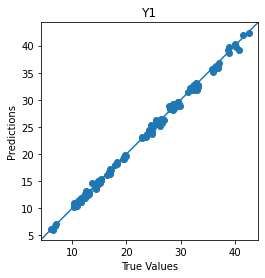

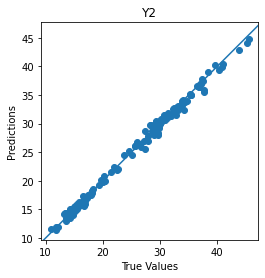

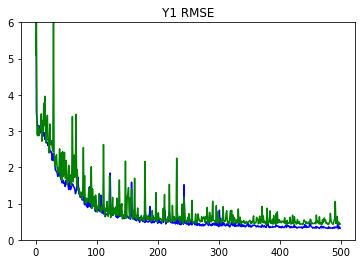

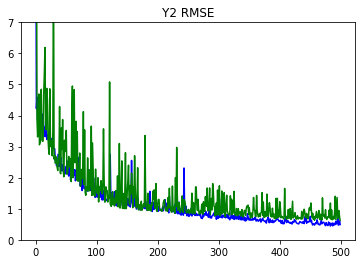

In [8]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)